# Speech recognition algorithm

The aim of the code is to develop and evaluate a machine learning model for audio classification tasks.
The code starts by preparing the dataset and extracting the target labels necessary for supervised learning. It then computes Mel-frequency cepstral coefficients (MFCCs) to capture essential audio characteristics. Utilizing K-Fold cross-validation, it evaluates multiple algorithms to determine the most suitable one. After splitting the data into training and testing subsets, it conducts a randomized search to optimize hyperparameters for improved model performance.

Following this, the code trains a Random Forest classifier, an ensemble learning method, on the training data. Finally, it evaluates the trained model on the testing data, reporting key performance metrics such as accuracy, precision, recall, and F1-score to assess its effectiveness in classification tasks.

In [48]:
import numpy as np
import pandas as pd
import librosa.display
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

## Data set preparation


In [49]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


In [50]:
n_mfcc = 20   # number of MFCC we will use
freq = 16000   # sampling rate

#getting the list of files from the local repository
from pathlib import Path

path_to_audio_folder = Path("free-spoken-digit-dataset/recordings")
audiofiles = [str(file) for file in path_to_audio_folder.glob('*.wav')]

# creating a dictionary to store data
data = {'mfcc':[], 'labels':[]}

for i,file in enumerate(audiofiles):
    fileid = file.split('/')[2]
    label  = fileid.split('_')[0]
    data["labels"].append(label)   #getting the labels

    #load the audio files
    audio, sr = librosa.load(file, sr=freq)

    #compute the MFCCs for each audio file
    mfcc = librosa.feature.mfcc(y=audio, sr=freq, n_fft =512, n_mfcc = n_mfcc)
    feature_vector =np.mean(mfcc, axis = 1)

    #features_matrix[i,:] = feature_vector
    data["mfcc"].append(feature_vector)


In [51]:
# verify that I got all the 3000 audio files
print('Got {} rows of data'.format(len(data['mfcc'])))

# create the flattened matrix of MFCCs -->  go from a list of arrays to a 2D matrix
MFCC_matrix =np.asarray( data['mfcc'])

# ...same for the labels vector
LABELS_vector = np.asarray(data["labels"])

print('Dimension of vector of labels is: {}'.format(LABELS_vector.shape))
print('Dimension of matrix of feautures is: {}'.format(MFCC_matrix.shape))

Got 3000 rows of data
Dimension of vector of labels is: (3000,)
Dimension of matrix of feautures is: (3000, 20)


In [52]:
# listen to the last audio file loaded
ipd.Audio(audio, rate=sr)

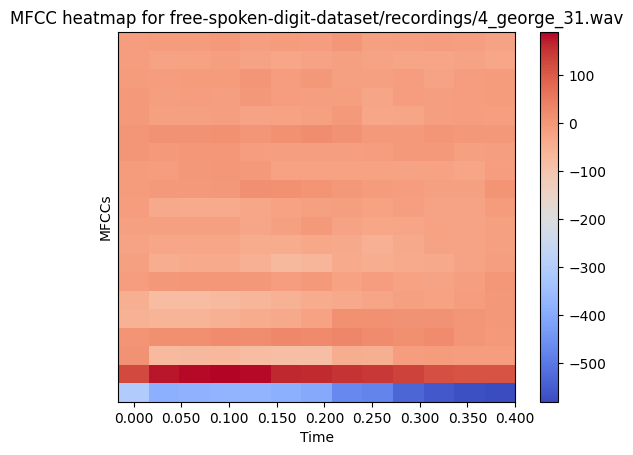

In [53]:
# check the MFCC heatmap for the last audio file
librosa.display.specshow(mfcc,x_axis = 'time',sr=sr)
plt.title('MFCC heatmap for {}'.format(file))
plt.xlabel('Time')
plt.ylabel('MFCCs')
plt.colorbar()
plt.show()

## K-Fold cross validation : Random Forest / SVC / kNN
### (using cross_val_score) (k=10)

The random state affects the splitting and that changes the accuracy score. We will evaluate the accuracy of these 3 algorithms using the K Fold cross validation. We will use the default values of the parameters during this process.


In [54]:
svm = SVC()                                  # initialize SVM
rf = RandomForestClassifier(n_jobs=2)        # initialize Random Forest
knn = KNeighborsClassifier()                 # initialize KNN

In [55]:
# support vector
print('The accuracy for the SVM is {}'.
      format(cross_val_score(svm, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the SVM is 0.6046666666666667


In [56]:
# random forest
print('The accuracy for the Random Forest is {}'.
      format(cross_val_score(rf, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the Random Forest is 0.9480000000000001


In [57]:
# kNN
print('The accuracy for the KNN is {}'.
      format(cross_val_score(knn, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the KNN is 0.915


The Random Forest algorithm shows the best performance.

## Proportionate splitting

In [58]:
# renaming
y = LABELS_vector
X = MFCC_matrix

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=0.2, stratify=y)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [59]:
# Check how the test sample are the same number for each digit
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'0': 240,
 '1': 240,
 '2': 240,
 '3': 240,
 '4': 240,
 '5': 240,
 '6': 240,
 '7': 240,
 '8': 240,
 '9': 240}

## Random Forest - fine tuning
### using RandomizedSearchCV
Having chosen the Random Forest algorithm we can proceed and evaluate the best parameters to use.

In [60]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,
'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

In [61]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# We have already created the base model to tune
# rf = RandomForestClassifier(n_jobs=2)

# Random search of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=2), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [62]:
# see the hyperparameters picked for the model
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

## PREDICTIONS AND RESULTS

In [63]:
#predict labels
predicted = rf_random.predict(X_test)

CONFUSION MATRIX _ RANDOM FOREST:


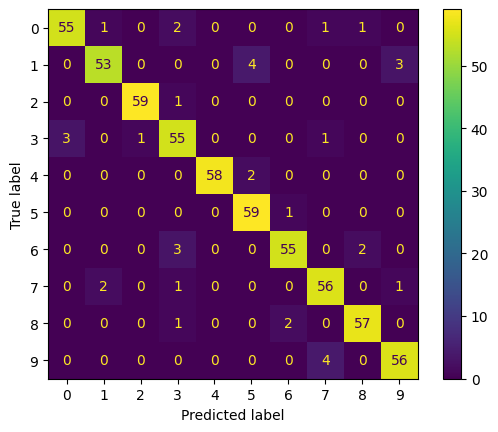

In [64]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

#confusion matrix
print('CONFUSION MATRIX _ RANDOM FOREST:')
#disp=plot_confusion_matrix(rf_random, X_test, y_test)
disp = ConfusionMatrixDisplay.from_estimator(rf_random, X_test, y_test)
plt.show()

In [65]:
#classification report
print('CLASSIFICATION REPORT _ RANDOM FOREST:\n\n',classification_report(y_test,predicted))
print('Accuracy:\n',accuracy_score(y_test, predicted))

CLASSIFICATION REPORT _ RANDOM FOREST:

               precision    recall  f1-score   support

           0       0.95      0.92      0.93        60
           1       0.95      0.88      0.91        60
           2       0.98      0.98      0.98        60
           3       0.87      0.92      0.89        60
           4       1.00      0.97      0.98        60
           5       0.91      0.98      0.94        60
           6       0.95      0.92      0.93        60
           7       0.90      0.93      0.92        60
           8       0.95      0.95      0.95        60
           9       0.93      0.93      0.93        60

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

Accuracy:
 0.9383333333333334


In [66]:
# check of the probabilities for a random sample
print("The label for this sample in y_test is {}".format((y_test)[60]))
print("The random forest predicted for it {}".format((predicted[60])))
a = rf_random.predict_proba(X_test)
print("Each class got these probabilities: {}".format(a[60]))

The label for this sample in y_test is 8
The random forest predicted for it 8
Each class got these probabilities: [0.03083333 0.00833333 0.0525     0.05833333 0.00583333 0.01666667
 0.02666667 0.005      0.76666667 0.02916667]
